In [1]:
%load_ext tensorboard

In [2]:
from typing import Optional, Callable, Union
import numpy as np
import pandas as pd

from pathlib import Path
import glob

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from itertools import groupby

import warnings
warnings.filterwarnings('ignore')

# custom class for Early Stop and function for fixing random seed
from early_stop import EarlyStopper
from random_seed import seed_everything

In [3]:
seed_everything(42)

In [4]:
pretrained_cnn_path ='Model/Pretrained_CNN/final_cnn.pt'

base_lr = 1e-4
max_lr = 0.01
batch_size = 64
epochs = 200

char_list = list('0123456789')

In [5]:
class SeqImg(Dataset):
    def __init__(self, folder_path='img/five_digits', transform=None):
        self.folder_path = folder_path
        self.files_list = glob.glob(self.folder_path + '/*.png', recursive=True)
        self.labels_list = [Path(x).name.split('_')[0] for x in self.files_list]
        self.data_df = pd.DataFrame({'file_path': self.files_list, 'label': self.labels_list})
        
        self.transform = transform
        
    def __len__(self):
        return len(self.files_list)
    
    def __getitem__(self, index: int):
        image = np.asarray(Image.open(self.files_list[index]))
        label_raw = self.labels_list[index]
        label = torch.Tensor([int(digit) for digit in label_raw])
        file_path = self.files_list[index]
        if self.transform is not None:
            image = self.transform(image)            
        return image, label, label_raw, file_path

In [6]:
trans_to_tensor = transforms.ToTensor()

In [7]:
img_dataset = SeqImg(transform=trans_to_tensor)

In [8]:
len(img_dataset)

20000

In [9]:
train_test_split_size = (len(img_dataset) - 1000, 1000)
train_val_ds, test_ds = random_split(img_dataset, train_test_split_size)

In [10]:
train_val_split_size = (len(train_val_ds) - 1000, 1000)
train_ds, val_ds = random_split(train_val_ds, train_val_split_size)

In [11]:
len(train_ds)

18000

In [12]:
def padding_collate(batch):
    imgs = torch.stack([items[0] for items in batch])
    seqs = [items[1] for items in batch]
    seqs = nn.utils.rnn.pad_sequence(seqs, padding_value=len(char_list), batch_first=True) # pad shorter seq with new class (class index=len(char_list))
    seqs_raw = [items[2] for items in batch]
    file_paths = [items[3] for items in batch]
    
    return imgs, seqs, seqs_raw, file_paths

In [13]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=padding_collate)
val_loader = DataLoader(val_ds, batch_size=1000, shuffle=True, collate_fn=padding_collate)
test_loader = DataLoader(test_ds, batch_size=1000, shuffle=True, collate_fn=padding_collate)

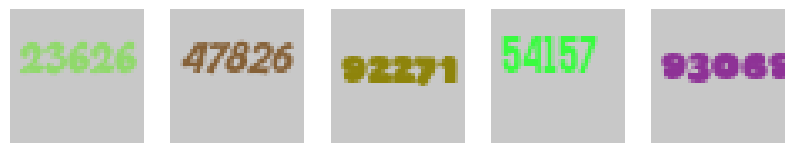

In [14]:
sample_img, sample_seqs, sample_seqs_raw, sample_file_path = next(iter(train_loader))

plt.rcParams['figure.figsize'] = (10, 6)
fig, axs = plt.subplots(ncols=5)

for i, img_arr in enumerate(sample_img[0:5]):
    axs[i].imshow(transforms.ToPILImage()(img_arr))
    axs[i].axis('off')

# Model Development

In [15]:
class CNN(nn.Module):
    # load pretrained CNN model, and keep the convolutional blocks only
    def __init__(self, model_path=pretrained_cnn_path):
        super().__init__()
        orig_cnn_model = torch.load(model_path)
        self.cnn = orig_cnn_model.conv_blocks
        
    def forward(self, X):
        X = self.cnn(X)
        return X

In [16]:
cnn_block = CNN()

In [17]:
cnn_block

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

In [18]:
cnn_out_channel = cnn_block.cnn[4].out_channels

In [19]:
char_list_padded = char_list + ['']

In [20]:
class CRNN(nn.Module):
    def __init__(self, char_list=char_list_padded, cnn=cnn_block, cnn_trainable=False, cnn_out_channel=cnn_out_channel,
                rnn_hidden_size=256, rnn_num_layers=2):
        super().__init__()
        
        self.char_list = char_list
        self.num_classes = len(self.char_list)
        
        self.cnn = cnn
        self.cnn_trainable = cnn_trainable
        
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        self.rnn = nn.GRU(cnn_out_channel * 10, # input: a sequence of 10 (40//4) tensors with size `cnn_out_channel` * 10 (40//4)
                          rnn_hidden_size, rnn_num_layers,
                          batch_first=False, bidirectional=True)
        self.fc = nn.Linear(rnn_hidden_size * 2, self.num_classes + 1) # * 2 due to bidirectional, + 1 due to the extra `blank` class from CTCLoss
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, X, decode=False, softmax=False):
        with torch.set_grad_enabled(self.cnn_trainable):
            features = self.cnn(X)
        features = self.features_to_seq(features)
        seq, hidden = self.rnn(features)
        seq = self.fc(seq)
        if softmax or decode:
            seq = self.softmax(seq)
        if decode:
            seq = self.decode(seq)
        return seq
    
    def features_to_seq(self, features):
        b, c, h, w = features.shape
        reshaped_features = features.view(b, c * h, w)
        reshaped_features = reshaped_features.permute(2, 0, 1) # input for GRU: (width (seq length), batch, input features)
        return reshaped_features
        
    def pred_to_str(self, pred):
        char_list_with_blank = self.char_list + [''] # `blank` label for CTCLoss, so 2 empty str ('') in the list here including the padding label
        out_str = ''.join([char_list_with_blank[i[0]] for i in groupby(pred)]) # `groupby` aggregated consecutive duplicates together
        return out_str
        
    def decode(self, pred):
        seq = [self.pred_to_str(seq_list) for seq_list in pred.argmax(dim=-1).permute(1, 0)]
        return seq

In [21]:
def train_crnn_model(data_loader: DataLoader = train_loader, base_lr: float = base_lr, max_lr: float = max_lr, epochs: int = epochs,
                    model_trained: Optional[nn.Module] = None, model_class: Optional[Callable] = None, cnn_trainable: bool = False,
                    num_epochs_to_save: float = np.inf, model_path: str = 'Model/CRNN', 
                    train_acc: bool = False, epochs_trained_before: int = 0,
                    early_stop: bool = False, es_after_epoch: int = 0, val_loader: Optional[DataLoader] = None, 
                    patience: int = 10, min_delta: float = 0, tensorboard_path: str = 'runs/CRNN',                              
                    **kwargs) -> nn.Module:
    
    """
    data_loader: Data Loader of training data.
    
    base_lr, max_lr, epochs: Hyperparameters.
    
    model_trained, model_class: Either a trained model instance (model_trained), or a model class that is callable (model_class) to create a new model instance. 
                                         
    cnn_trainable: params of CNN will be freezed and untrainable if it is False. Else, the params will be updated in the training process.
    
    num_epochs_to_save, model_path: For every `num_epochs_to_save` epochs, th emodel will be saved to folder `model_path`. `num_epochs_to_save=np.inf` means never save the model.
    
    train_acc: Calculate the training accuracy for every epoch (and send to Tensorboard) or not
    
    epochs_trained_before: if the model is trained before, this number is added to the number of epochs in this training process. Useful when passing a trained model to here for more training epochs.
    
    early_stop: Early Stop or not.
    
    es_after_epoch: Epochs smaller than `es_after_epoch` will not trigger the calculation of early stop.
    
    val_loader: Data Loader of validation data (for early stop).
    
    patience, min_delta: arguments for `EarlyStopper`
    
    tensorboard_path: Folder path where the `SummaryWriter` for Tensorboard to write the data to
    
    kwargs: arguments for the callable model class(if any)    
    """
    
    writer = SummaryWriter(tensorboard_path)
    
    Path(model_path).mkdir(parents=True, exist_ok=True)
    
    model_to_train = model_trained or model_class(**kwargs)
    model_to_train.cnn_trainable = cnn_trainable
    
    opt = optim.SGD(model_to_train.parameters(), lr=base_lr)
    steps_per_epoch = len(data_loader) * 2
    scheduler = optim.lr_scheduler.CyclicLR(opt, base_lr=base_lr, max_lr=max_lr, step_size_up=steps_per_epoch)
    blank_class = len(model_to_train.char_list)
    loss_fn = nn.CTCLoss(blank=blank_class)
    
    if early_stop:
        early_stopper = EarlyStopper(patience, min_delta)
        
    for epoch in tqdm(range(epochs_trained_before, epochs_trained_before + epochs), position=0):
        model_to_train.train()
        tot_loss = 0
        num_data = 0
        for inputs, targets, *_ in data_loader:
            opt.zero_grad()
            y_pred = model_to_train(inputs)
            pred_lens = torch.full((targets.shape[0],), y_pred.shape[0], dtype=int)
            target_lens = torch.full((targets.shape[0],), targets.shape[1], dtype=int)
            loss = loss_fn(y_pred.log_softmax(dim=-1), targets, pred_lens, target_lens)
            tot_loss += loss * len(targets)
            num_data += len(targets)
            loss.backward()
            opt.step()
            scheduler.step()
        writer.add_scalar('Loss/train', tot_loss / num_data, epoch)
        
        if not( (epoch + 1) % num_epochs_to_save):
            Path(model_path).mkdir(parents=True, exist_ok=True)
            torch.save(model_to_train, model_path + f'/model_ep{epoch + 1}.pt')
        
        if train_acc:
            model_to_train.eval()
            correct_train = 0
            for inputs, targets, target_raw, file_path in data_loader:
                y_pred = model_to_train(inputs, decode=True)
                correct_train += sum([a==b for a, b in zip(y_pred, target_raw)])
            writer.add_scalar('Accuracy/train', correct_train / num_data, epoch)
            
        if early_stop and (epoch + 1) > es_after_epoch:
            model_to_train.eval()
            tot_val_loss = 0
            num_val_data = 0
            for inputs, targets, *_ in val_loader:
                y_pred = model_to_train(inputs)
                pred_lens = torch.full((targets.shape[0],), y_pred.shape[0], dtype=int)
                target_lens = torch.full((targets.shape[0],), targets.shape[1], dtype=int)
                loss = loss_fn(y_pred.log_softmax(dim=-1), targets, pred_lens, target_lens)
                tot_val_loss += loss * len(targets)
                num_val_data += len(targets)
            writer.add_scalar('Loss/validation', tot_val_loss / num_val_data, epoch)
            stop_training = early_stopper(tot_val_loss / num_val_data)
            if stop_training:
                print(f"Training early stopped at Epoch {epoch + 1}.")
                torch.save(model_to_train, model_path + f'/model_ep{epoch + 1}.pt')
                writer.flush()
                writer.close()
                return model_to_train
    
    torch.save(model_to_train, model_path + f'/model_ep{epoch + 1}.pt')
    writer.flush()
    writer.close()
    return model_to_train

In [22]:
crnn_model = train_crnn_model(model_class=CRNN, epochs=5)

100%|█████████████████████████████████████████████| 5/5 [05:18<00:00, 63.64s/it]


In [23]:
%tensorboard --logdir=runs/CRNN

In [24]:
crnn_model = train_crnn_model(model_trained=crnn_model, epochs=200, epochs_trained_before=5,
                              num_epochs_to_save = 10, es_after_epoch=100, 
                              patience=20, min_delta=0.005,
                              early_stop=True, val_loader=val_loader)

 62%|██████████████████████▌             | 125/200 [7:46:30<4:39:54, 223.92s/it]

Training early stopped at Epoch 131.


In [25]:
# check the recognition result on some sample images from training data
crnn_model.eval()
pred_decoded = crnn_model(sample_img, decode=True)

In [26]:
sum([a==b for a, b in zip(pred_decoded, sample_seqs_raw)])

60

In [27]:
def compare_pred(pred_seq=pred_decoded, actual_seq=sample_seqs_raw, ind=0, img=sample_img, plt_img=False):
    if plt_img:
        plt.imshow(transforms.ToPILImage()(img[ind]))
    print(f'Acutal Seq: {actual_seq[ind]}')
    print(f'Predicted Seq: {pred_seq[ind]}')
    return 'Recognition Correct.' if actual_seq[ind] == pred_seq[ind] else 'Recognition failed!'

Acutal Seq: 23626
Predicted Seq: 23626


'Recognition Correct.'

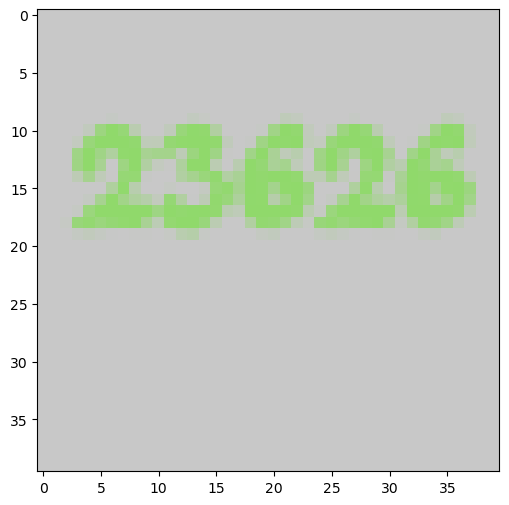

In [28]:
compare_pred(plt_img=True)

Acutal Seq: 05470
Predicted Seq: 05476


'Recognition failed!'

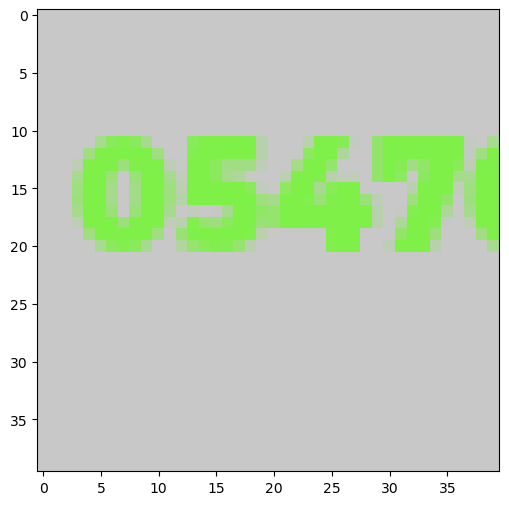

In [29]:
failed_rec_ind = np.array([a != b for a, b in zip(pred_decoded, sample_seqs_raw)]).argmax()
compare_pred(plt_img=True, ind=failed_rec_ind)

# Model Evaluation

In [30]:
def eval_prediction(model=crnn_model, loader=val_loader):
    model.eval()
    pred_df_list = []
    for inputs, targets, target_raw, file_path in loader:
        y_pred = model(inputs, decode=True)
        pred_df_list += [pd.DataFrame({'img_path': file_path, 'actual_label': target_raw, 'pred': y_pred})]
        
    pred_df = pd.concat(pred_df_list, ignore_index=True)
    
    print(f"Accuracy Score: {accuracy_score(pred_df['actual_label'], pred_df['pred'])}")
    return pred_df

In [31]:
acc_df = eval_prediction(loader=train_loader)

Accuracy Score: 0.9460555555555555


In [32]:
val_df = eval_prediction()

Accuracy Score: 0.832


In [33]:
crnn_120 = torch.load('Model/CRNN/model_ep120.pt')
val_120_df = eval_prediction(model=crnn_120)

Accuracy Score: 0.844


In [34]:
crnn_130 = torch.load('Model/CRNN/model_ep130.pt')
val_130_df = eval_prediction(model=crnn_130)

Accuracy Score: 0.842


In [35]:
# since the model at 120th epoch had a better accuracy on validation data, it is chosen to be the final model.
final_model = crnn_120

In [36]:
test_df = eval_prediction(model=final_model, loader=test_loader)

Accuracy Score: 0.835


In [37]:
long_img_seq = SeqImg(folder_path='img/12_digits', transform=trans_to_tensor)

In [38]:
long_img_loader = DataLoader(long_img_seq, batch_size=100, collate_fn=padding_collate)

In [39]:
final_model.eval()

for long_img, long_labels, long_labels_raw, long_file_path in long_img_loader:
    long_pred = final_model(long_img, decode=True)

print(f"Number of correct recognition: {sum(a == b for a, b in zip(long_pred, long_labels_raw))}")
print(f"Number of incorrect recognition: {sum(a != b for a, b in zip(long_pred, long_labels_raw))}")

Number of correct recognition: 52
Number of incorrect recognition: 48


In [40]:
torch.save(final_model, 'Model/CRNN/final_CRNN_model.pt')